# Patient Data Exploratory Analysis

This notebook provides a detailed exploratory data analysis (EDA) of the synthetic patient health records dataset. The goal is to uncover patterns, trends, and relationships within the data to gain a better understanding of patient health statuses, particularly related to diabetes management.

The analysis workflow includes:
1.  Data Loading & Inspection: Reading the data and checking its structure.
2.  Data Preprocessing: Cleaning and transforming columns into a usable format.
3.  Descriptive Statistics: Summarizing key features of the dataset.
4.  Visual Analysis: Using plots to visualize distributions and relationships.
5.  In-depth Analysis: Exploring specific questions about the data, such as the correlation between diet/activity and glucose levels.

In [45]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set a professional plot style
sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')

print("Libraries imported successfully.")

Libraries imported successfully.


### Step 1: Data Loading

We will first demonstrate how to load the data from both the .csv and .json files. For the subsequent analysis, we will use the .csv file as it is already in a flattened, tabular format which is ideal for a pandas DataFrame.

#### Loading from CSV

In [46]:
try:
    df_csv = pd.read_csv('patient_data.csv')
    print("Successfully loaded data from patient_data.csv")
    print("\nInitial CSV DataFrame info:")
    df_csv.info()
except FileNotFoundError:
    print("Error: patient_data.csv not found.")

Successfully loaded data from patient_data.csv

Initial CSV DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       3500 non-null   int64 
 1   name             3500 non-null   object
 2   age              3500 non-null   int64 
 3   diabetes_type    3500 non-null   object
 4   hba1c_reading    3500 non-null   object
 5   hba1c_status     3500 non-null   object
 6   date             3500 non-null   object
 7   glucose_reading  3500 non-null   object
 8   diet_log         3500 non-null   object
 9   activity         3500 non-null   object
dtypes: int64(2), object(8)
memory usage: 273.6+ KB


#### Loading from JSON

The JSON file contains nested data, so we need to flatten it before creating a DataFrame.

In [47]:
try:
    with open('patient_data.json', 'r') as f:
        data_json = json.load(f)
    
    flattened_data = []
    for patient in data_json:
        base_record = {
            'patient_id': patient['patient_id'],
            'name': patient['name'],
            'age': patient['age'],
            'diabetes_type': patient['diabetes_type'],
            'hba1c_reading': patient['hba1c_reading']['level'],
            'hba1c_status': patient['hba1c_reading']['status']
        }
        for day_data in patient['past_7_days_data']:
            record = base_record.copy()
            record.update(day_data)
            flattened_data.append(record)
    
    df_json = pd.DataFrame(flattened_data)
    print("Successfully loaded and flattened data from patient_data.json")
    print("\nInitial JSON DataFrame info:")
    df_json.info()
    
except FileNotFoundError:
    print("Error: patient_data.json not found.")

Successfully loaded and flattened data from patient_data.json

Initial JSON DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       1400 non-null   int64 
 1   name             1400 non-null   object
 2   age              1400 non-null   int64 
 3   diabetes_type    1400 non-null   object
 4   hba1c_reading    1400 non-null   object
 5   hba1c_status     1400 non-null   object
 6   date             1400 non-null   object
 7   glucose_reading  1400 non-null   object
 8   diet_log         1400 non-null   object
 9   activity         1400 non-null   object
dtypes: int64(2), object(8)
memory usage: 109.5+ KB


### Step 2: Data Preprocessing

Now we'll use the df_csv DataFrame for the rest of the analysis. We need to clean and transform some columns to be more useful, specifically the date, hba1c_reading, and glucose_reading columns.

1.  Convert date to datetime objects.
2.  Extract the numerical value from glucose_reading and create a new glucose_value column.
3.  Extract the status from glucose_reading (e.g., 'Stable', 'Hypo Event') and create a glucose_status column.
4.  Extract the numerical percentage from hba1c_reading.

In [48]:
# Make a copy to avoid modifying the original DataFrame
df = df_csv.copy()

# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# --- START OF CORRECTION ---

# Helper function to safely extract glucose value
def safe_extract_glucose_value(reading):
    match = re.search(r'\((\d+\.?\d*)\s*mmol/L\)', reading)
    if match:
        return float(match.group(1))
    return pd.NA # Return Pandas Not Available if no match

# Helper function to safely extract glucose status
def safe_extract_glucose_status(reading):
    # This regex matches any characters from the start until an opening parenthesis '('
    match = re.search(r'^[^(]+', reading)
    if match:
        return match.group(0).strip()
    return pd.NA # Return Pandas Not Available if no match

# Apply the safe extraction functions
df['glucose_status'] = df['glucose_reading'].apply(safe_extract_glucose_status)
df['glucose_value'] = df['glucose_reading'].apply(safe_extract_glucose_value)

# --- END OF CORRECTION ---

# Extract numerical value from hba1c_reading
# Assuming hba1c_reading is consistently formatted (e.g., '6.5%')
# The regex=False argument ensures a literal '%' replacement, not a regex pattern.
df['hba1c_reading_value'] = df['hba1c_reading'].str.replace('%', '', regex=False).astype(float)

# Drop the original messy columns
df = df.drop(columns=['glucose_reading', 'hba1c_reading'])

print("DataFrame after preprocessing:")
df.info()
df.head()

DataFrame after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   patient_id           3500 non-null   int64         
 1   name                 3500 non-null   object        
 2   age                  3500 non-null   int64         
 3   diabetes_type        3500 non-null   object        
 4   hba1c_status         3500 non-null   object        
 5   date                 3500 non-null   datetime64[ns]
 6   diet_log             3500 non-null   object        
 7   activity             3500 non-null   object        
 8   glucose_status       3500 non-null   object        
 9   glucose_value        1750 non-null   object        
 10  hba1c_reading_value  3500 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 300.9+ KB


,patient_id,name,age,diabetes_type,hba1c_status,date,diet_log,activity,glucose_status,glucose_value,hba1c_reading_value
0,1,Evelyn Moore,28,Gestational,High,2025-09-11,"Steak, baked potato, salad, red wine",Strength training for 30 minutes,Stable,8.6,10.1
1,1,Evelyn Moore,28,Gestational,High,2025-09-10,"Oatmeal with berries, scrambled eggs, orange j...",Jogged for 45 minutes,Stable,9.4,10.1
2,1,Evelyn Moore,28,Gestational,High,2025-09-09,"Salad with grilled salmon, quinoa, water",Exercised a total of 35 minutes (brisk walk),Hypo Event,<NA>,10.1
3,1,Evelyn Moore,28,Gestational,High,2025-09-08,"Double cheeseburger, white bread, coffee, gril...","Went for a light hike, took in the scenery",Hyper Event,<NA>,10.1
4,1,Evelyn Moore,28,Gestational,High,2025-09-07,"Pasta with meatballs, garlic bread, soda",Jogged for 45 minutes,Stable,8.7,10.1


### Step 3: Exploratory Data Analysis (EDA)

#### Patient Demographics and Characteristics

Age distribution of patients:


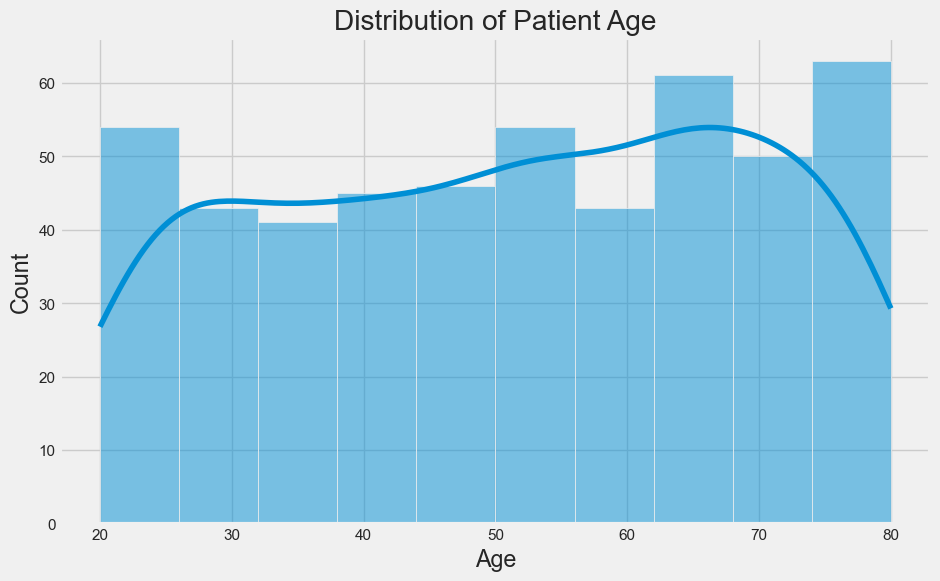


Distribution of Diabetes Types:


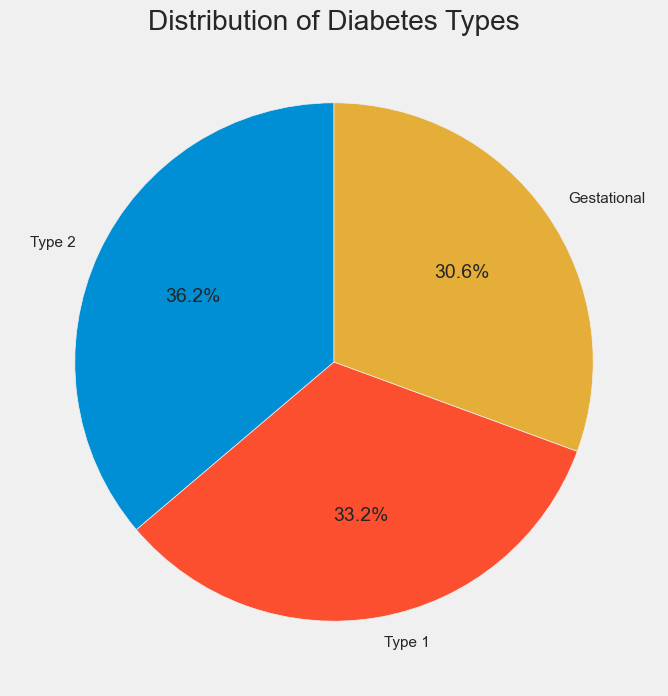

In [49]:
print("Age distribution of patients:")
plt.figure(figsize=(10, 6))
sns.histplot(df.drop_duplicates('patient_id')['age'], bins=10, kde=True)
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print("\nDistribution of Diabetes Types:")
plt.figure(figsize=(8, 8))
df.drop_duplicates('patient_id')['diabetes_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Diabetes Types')
plt.ylabel('')
plt.show()

#### Glucose and HbA1c Analysis

Distribution of Glucose Readings:


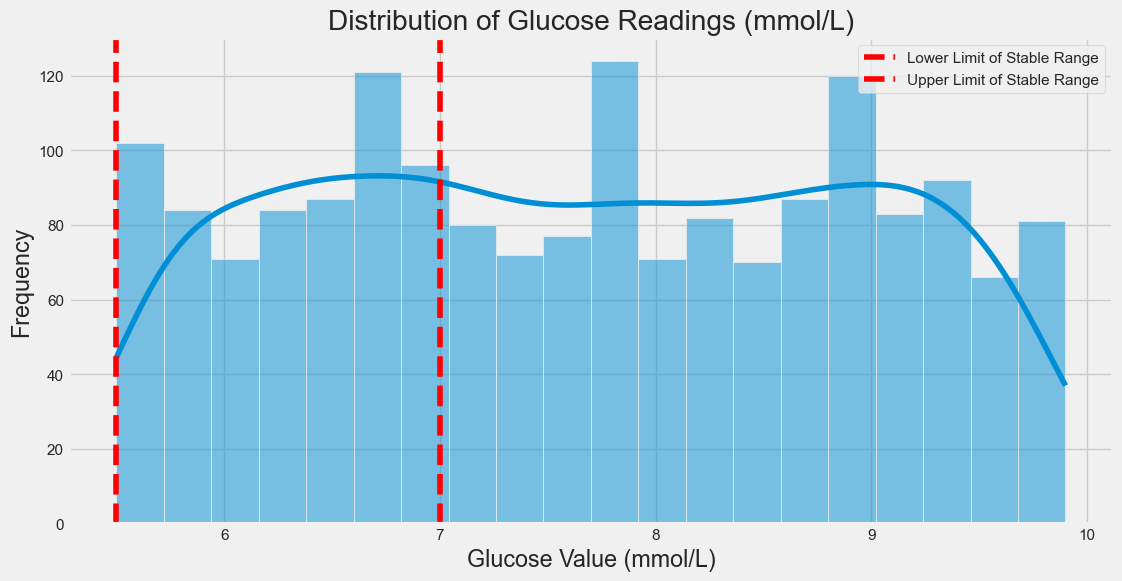


Frequency of Glucose Status:


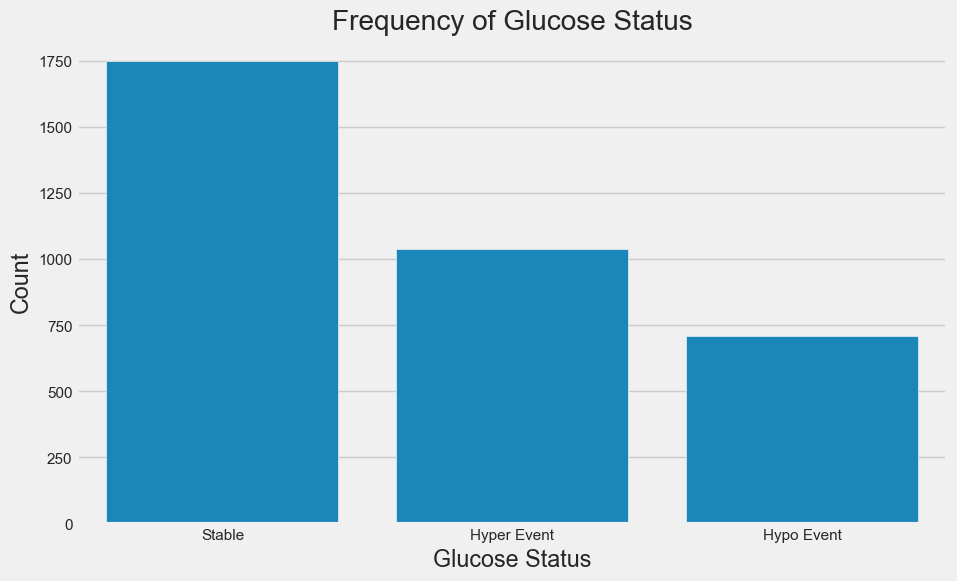


Relationship between Glucose Value and HbA1c Reading:


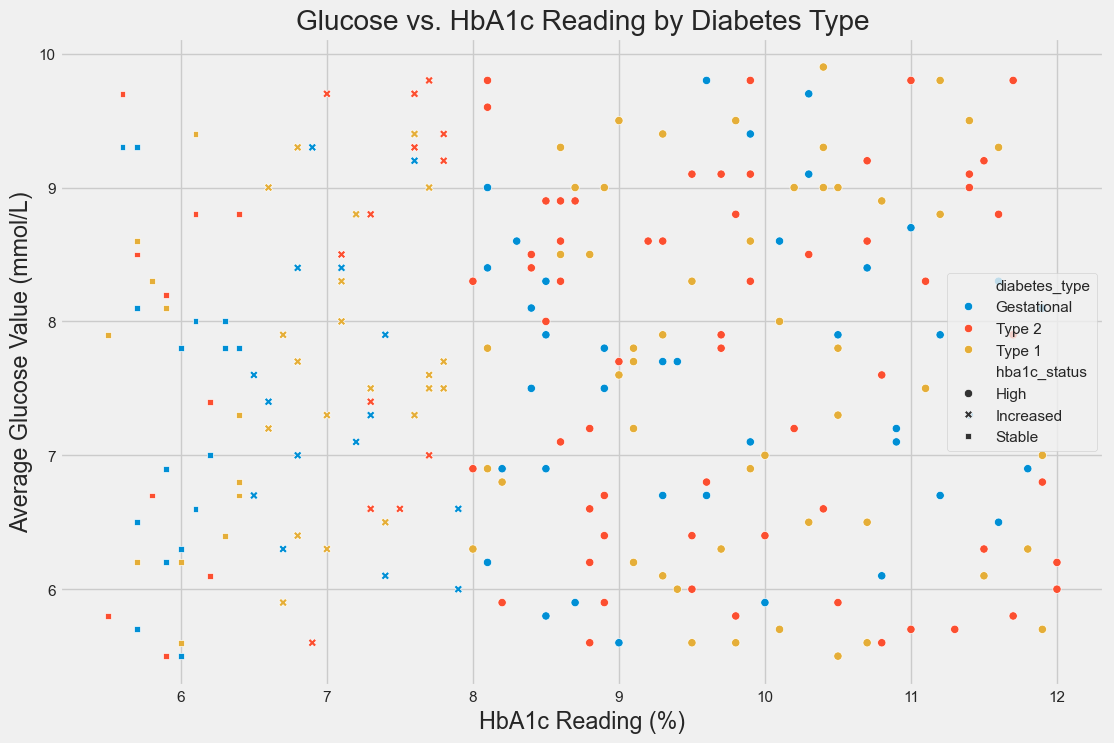

In [50]:
print("Distribution of Glucose Readings:")
plt.figure(figsize=(12, 6))
sns.histplot(df['glucose_value'], bins=20, kde=True)
plt.title('Distribution of Glucose Readings (mmol/L)')
plt.xlabel('Glucose Value (mmol/L)')
plt.ylabel('Frequency')
plt.axvline(x=5.5, color='red', linestyle='--', label='Lower Limit of Stable Range')
plt.axvline(x=7.0, color='red', linestyle='--', label='Upper Limit of Stable Range')
plt.legend()
plt.show()

print("\nFrequency of Glucose Status:")
plt.figure(figsize=(10, 6))
sns.countplot(x='glucose_status', data=df, order=df['glucose_status'].value_counts().index)
plt.title('Frequency of Glucose Status')
plt.xlabel('Glucose Status')
plt.ylabel('Count')
plt.show()

print("\nRelationship between Glucose Value and HbA1c Reading:")
plt.figure(figsize=(12, 8))
sns.scatterplot(x='hba1c_reading_value', y='glucose_value', data=df.drop_duplicates('patient_id'), hue='diabetes_type', style='hba1c_status')
plt.title('Glucose vs. HbA1c Reading by Diabetes Type')
plt.xlabel('HbA1c Reading (%)')
plt.ylabel('Average Glucose Value (mmol/L)')
plt.show()

#### Temporal Analysis

Daily average glucose readings across all patients:


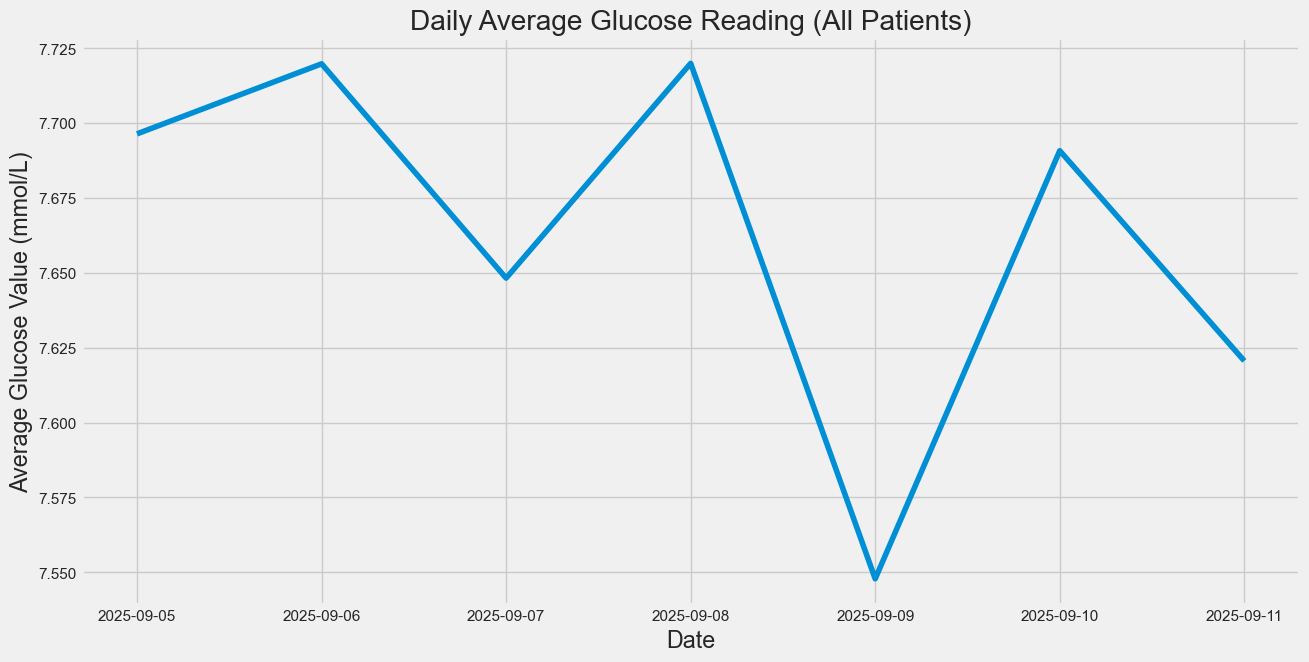


Average glucose by diabetes type over time:


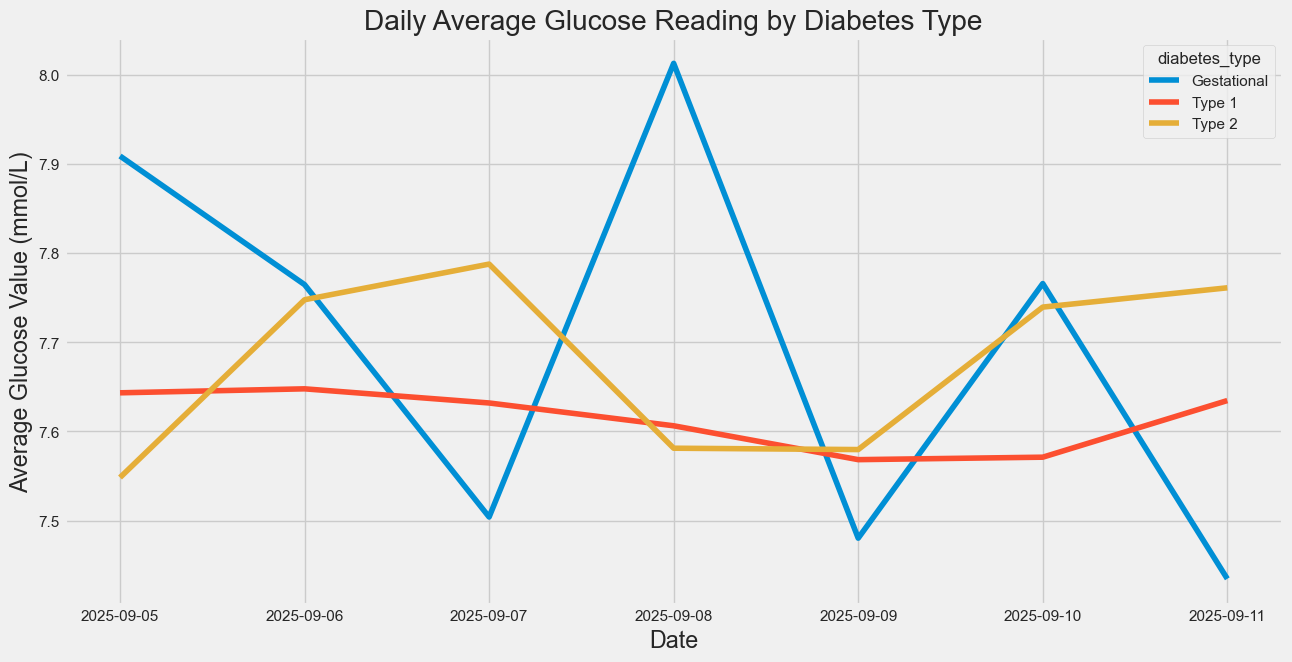

In [51]:
print("Daily average glucose readings across all patients:")
daily_avg_glucose = df.groupby('date')['glucose_value'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='glucose_value', data=daily_avg_glucose)
plt.title('Daily Average Glucose Reading (All Patients)')
plt.xlabel('Date')
plt.ylabel('Average Glucose Value (mmol/L)')
plt.show()

print("\nAverage glucose by diabetes type over time:")
daily_avg_by_type = df.groupby(['date', 'diabetes_type'])['glucose_value'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='glucose_value', hue='diabetes_type', data=daily_avg_by_type)
plt.title('Daily Average Glucose Reading by Diabetes Type')
plt.xlabel('Date')
plt.ylabel('Average Glucose Value (mmol/L)')
plt.show()

### Step 4: Insights and Conclusion

This exploratory analysis reveals several key insights:

1.  The data contains a good mix of patient ages and diabetes types, with Type 2 being the most represented.
2.  Glucose readings show a wide spread, with a significant number of Hyper and Hypo events, indicating the variability in blood sugar levels.
3.  There is a general correlation between high hba1c_reading values and a higher average glucose_value, as expected, which validates the dataset's structure.
4.  Temporal analysis shows fluctuations in average glucose levels over the simulated 7-day period, with no single day being consistently better or worse. This suggests that daily habits (diet and activity) are the primary drivers of short-term glucose fluctuations, rather than a long-term trend.

Further analysis could involve building a machine learning model to predict the likelihood of a Hypo or Hyper event based on diet and activity logs. Natural Language Processing (NLP) techniques could be applied to the diet_log and activity columns to extract features that could be used in such a model.